A bunch of standard imports


In [1]:
import matplotlib.pyplot as plt
from keras.datasets import mnist #import the mnist dataset
import numpy as np

The GAN class (Generator and discriminator)

In [2]:
class GAN:
    def __init__(self, numbers, epochs=100, batch_size=64, input_size_gen=100,
                 hidden_size_gen=128, hidden_size_disc=128, learning_rate=1e-3,
                 decay_rate=1e-4, img_size=28, display_epochs=5):

        self.numbers = numbers #number (list) whose image is to be generated
        self.epochs = epochs #max iterations
        self.learning_rate = learning_rate #learning rate
        self.decay_rate = decay_rate #decay of learning rate
        self.batch_size = batch_size #batch size of data
        self.input_size_gen = input_size_gen #size of the input layer of the generator
        self.hidden_size_gen = hidden_size_gen #size of the hidden layer of the generator
        self.hidden_size_disc = hidden_size_disc #size of the hidden layer of the discriminator
        self.img_size = img_size #28x28 image
        self.display_epochs = display_epochs #display iterations

        #Initialize random values for the generator (weight matrix and bias node)
        self.weight_matrix_gen = np.random.randn(self.input_size_gen, self.hidden_size_gen) * np.sqrt(2. / self.input_size_gen)  
        self.generator_bias_0 = np.zeros((1, self.hidden_size_gen))  
        self.weight_matrix_gen_2 = np.random.randn(self.hidden_size_gen, self.img_size ** 2) * np.sqrt(2. / self.hidden_size_gen)  
        self.generator_bias_1 = np.zeros((1, self.img_size ** 2))  

        #Initialize random values for the discriminator (weight matrix and bias node)
        self.weight_matrix_disc_1 = np.random.randn(self.img_size ** 2, self.hidden_size_disc) * np.sqrt(2. / self.img_size ** 2)  
        self.disc_bias_1 = np.zeros((1, self.hidden_size_disc))  
        self.weight_matrix_disc_2 = np.random.randn(self.hidden_size_disc, 1) * np.sqrt(2. / self.hidden_size_disc) 
        self.disc_bias_2 = np.zeros((1, 1))  
    


    '''
    A bunch of activation functions
    '''
    def grad_tanh(self, x):
        #tanh activation function
        return 1. - np.tanh(x) ** 2

    def lrelu(self, x, alpha=1e-2):
        #Leaky ReLu function (alpha = gradient of the mapping function)
        return np.maximum(x, x * alpha)

    def grad_lrelu(self, x, alpha=1e-2):
        #Derivative of the leaky ReLu function       
        dx = np.ones_like(x)
        dx[x < 0] = alpha
        return dx

    def sigmoid(self, x):
        #Compute the sigmoid of a matrix and return a numpy array
        return 1. / (1. + np.exp(-x))

    def grad_sigmoid(self, x):
        #Return the derivative of the sigmoid for a given input matrix X
        return self.sigmoid(x) * (1. - self.sigmoid(x))

    

    '''
    Show the generated images
    '''
    def show_img(self, images, epoch, state):
        """Generate a grid with sample images from the generator
            images -> generated images (numpy array)
            epoch -> current training iteration
            state -> if True, the grid of images is displayed
        """
        images = np.reshape(images, (self.batch_size, self.img_size, self.img_size))
        fig = plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        if state == True:
            plt.show()
        else:
            plt.close()



    #Implement forward and backward discriminator and generator
    def fwd_gen(self, rand_noise):
        '''Implement forward prop via the generator
          rand_noise -> random noise
          logit_out_gen -> logit output 
          gen_img -> generated image'''
        self.layer1_gen = np.dot(rand_noise, self.weight_matrix_gen) + self.generator_bias_0
        self.activation_l1_gen = self.lrelu(self.layer1_gen, alpha=0)
        self.logit_out_gen = np.dot(self.activation_l1_gen, self.weight_matrix_gen_2) + self.generator_bias_1
        self.gen_img = np.tanh(self.logit_out_gen)  
        return self.logit_out_gen, self.gen_img

    def fwd_disc(self, img_batch):
        '''Forward prop via the discriminator
          img_batch -> image batch
          logit_out_disc -> logit output
          prediction_fwd -> prediction of nature of images'''
        self.layer1_disc = np.dot(img_batch, self.weight_matrix_disc_1) + self.disc_bias_1
        self.activation_l1_disc = self.lrelu(self.layer1_disc)
        self.logit_out_disc = np.dot(self.activation_l1_disc, self.weight_matrix_disc_2) + self.disc_bias_2
        self.prediction_fwd = self.sigmoid(self.logit_out_disc)  
        return self.logit_out_disc, self.prediction_fwd

    def disc_backprop(self, real_img_batch, logit_real_out, a1_real, x_fake, z1_fake, a1_fake):
        """Implement back prop via the discriminator
            real_img_batch -> real image batch
            logit_real_out -> logit ouput (real images)
            a1_real -> ouput prediction (real images)
            x_fake -> fake generated images
            z1_fake -> logit output (fake images)
            a1_fake -> output prediction (fake images) """
        #Sigmoid(real)
        grad_activation1_real = -1. / (a1_real + 1e-8) 
        grad_logit_real_out = grad_activation1_real * self.grad_sigmoid(logit_real_out)  
        grad_weight1_real = np.dot(self.activation_l1_disc.T, grad_logit_real_out)
        grad_bias1_real = np.sum(grad_logit_real_out, axis=0, keepdims=True)
        #ReLu(real)
        grad_activation0_real = np.dot(grad_logit_real_out, self.weight_matrix_disc_2.T)
        grad_logit0_real = grad_activation0_real * self.grad_lrelu(self.layer1_disc)
        grad_weight0_real = np.dot(real_img_batch.T, grad_logit0_real)
        grad_bias0_real = np.sum(grad_logit0_real, axis=0, keepdims=True)
        #Fake input gradients
        grad_activation1_fake = 1. / (1. - a1_fake + 1e-8)
        #Sigmoid(fake)
        grad_logit1_fake = grad_activation1_fake * self.grad_sigmoid(z1_fake)
        grad_weight1_fake = np.dot(self.activation_l1_disc.T, grad_logit1_fake)
        grad_bias1_fake = np.sum(grad_logit1_fake, axis=0, keepdims=True)
        #ReLu(fake)
        grad_activation0_fake = np.dot(grad_logit1_fake, self.weight_matrix_disc_2.T)
        grad_logit0_fake = grad_activation0_fake * self.grad_lrelu(self.layer1_disc, alpha=0)
        grad_weight0_fake = np.dot(x_fake.T, grad_logit0_fake)
        grad_bias0_fake = np.sum(grad_logit0_fake, axis=0, keepdims=True)
        #Net gradient (real + fake)
        grad_weight1 = grad_weight1_real + grad_weight1_fake
        grad_bias1 = grad_bias1_real + grad_bias1_fake
        grad_weight0 = grad_weight0_real + grad_weight0_fake
        grad_bias0 = grad_bias0_real + grad_bias0_fake
        #Use stochastic gradient descent to update gradients in each pass
        self.weight_matrix_disc_1 -= self.learning_rate * grad_weight0
        self.disc_bias_1 -= self.learning_rate * grad_bias0
        self.weight_matrix_disc_2 -= self.learning_rate * grad_weight1
        self.disc_bias_2 -= self.learning_rate * grad_bias1



    def gen_backprop(self, z, x_fake, z1_fake, a1_fake):
        """Implement back prop via the discriminator
            z -> random noise
            x_fake -> generated fake images
            z1_fake -> logit output (discriminator)
            a1_fake -> output prediction (discriminator)"""
  
        #Gradient for the fake inputs
        grad_activation1_disc = -1.0 / (a1_fake + 1e-8)  
        #Sigmoid gradients
        grad_logit1_disc = grad_activation1_disc * self.grad_sigmoid(z1_fake)
        grad_activation0_disc = np.dot(grad_logit1_disc, self.weight_matrix_disc_2.T)
        #ReLu gradients
        grad_logit0_disc = grad_activation0_disc * self.grad_lrelu(self.layer1_disc)
        relu_grad = np.dot(grad_logit0_disc, self.weight_matrix_disc_1.T)
        #tanh gradients
        grad_logit1_gen = relu_grad * self.grad_tanh(self.logit_out_gen)
        grad_weight1_gen = np.dot(self.activation_l1_gen.T, grad_logit1_gen)
        grad_bias1_gen = np.sum(grad_logit1_gen, axis=0, keepdims=True)      
        #ReLu gradients
        grad_activation0_gen = np.dot(grad_logit1_gen, self.weight_matrix_gen_2.T)
        grad_logit0_gen = grad_activation0_gen * self.grad_lrelu(self.layer1_gen, alpha=0)
        grad_weight0_gen = np.dot(z.T, grad_logit0_gen)
        grad_bias0_gen = np.sum(grad_logit0_gen, axis=0, keepdims=True)
        #Update the gradients using stochastic gradient descent
        self.weight_matrix_gen -= self.learning_rate * grad_weight0_gen
        self.generator_bias_0 -= self.learning_rate * grad_bias0_gen
        self.weight_matrix_gen_2 -= self.learning_rate * grad_weight1_gen
        self.generator_bias_1 -= self.learning_rate * grad_bias1_gen


    #Process available data
    def img_process(self, training_img, training_labels):
        """Processes the training images and labels:
            training_img -> training images
            training_labels ->  training labels
            final_train_img -> processed training images
            y_train -> processed training labels
            num_batches - number of batches"""
        final_train_img = []
        y_train = []
        #limit the data to digits from 0-9 (since GANs can take hours to train)
        for i in range(training_labels.shape[0]):
            if training_labels[i] in self.numbers:
                final_train_img.append(training_img[i])
                y_train.append(training_labels[i])
        final_train_img = np.array(final_train_img)
        y_train = np.array(y_train)

        #full batches
        num_batches = final_train_img.shape[0] // self.batch_size
        final_train_img = final_train_img[: num_batches * self.batch_size]
        y_train = y_train[: num_batches * self.batch_size]
        # flatten images
        final_train_img = np.reshape(final_train_img, (final_train_img.shape[0], -1))
        # normalise data
        final_train_img = (final_train_img.astype(np.float32) - 127.5) / 127.5
        # shuffle the data for convergence
        rand_img = np.random.permutation(len(final_train_img))
        final_train_img, y_train = final_train_img[rand_img], y_train[rand_img]
        return final_train_img, y_train, num_batches


    #Train the GAN
    def train(self, tr_data, tr_labels):
        """Main method to train the GAN
            tr_data -> training data
            tr_labels -> training labels
            cost_func_disc -> discriminator loss for each pass
            cost_func_gen -> generator loss for each pass 
        """
        cost_func_disc = []  #discriminator loss
        cost_func_gen = []  #generator loss
        #process data
        final_train_img, _, num_batches = self.img_process(tr_data, tr_labels)
        for epoch in range(self.epochs):
            for i in range(num_batches):
                #input batch and noise
                x_real = final_train_img[i * self.batch_size: (i + 1) * self.batch_size]
                z = np.random.normal(0, 1, size=[self.batch_size, self.input_size_gen])  
                #forward prop (generator)
                z1_gen, x_fake = self.fwd_gen(z)
                z1_d_real, a1_d_real = self.fwd_disc(x_real)
                z1_d_fake, a1_d_fake = self.fwd_disc(x_fake)
                # cross entropy loss (a slightly different implentation from Ian Goodfellow's paper)
                disc_cost = np.mean(-np.log(a1_d_real) - np.log(1 - a1_d_fake))
                cost_func_disc.append(disc_cost)
                gen_cost = np.mean(-np.log(a1_d_fake))
                cost_func_gen.append(gen_cost)
                #back prop
                self.disc_backprop(x_real, z1_d_real, a1_d_real, x_fake, z1_d_fake, a1_d_fake)
                self.gen_backprop(z, x_fake, z1_d_fake, a1_d_fake)

            if epoch % self.display_epochs == 0:
                print(f"epoch:{epoch:}|gen_cost:{gen_cost:.6f}|disc_loss:{disc_cost:.6f}|learning_rate:{self.learning_rate:.6f}")
                self.show_img(x_fake, epoch, state=True)  # display sample images
            else:
                self.show_img(x_fake, epoch, state=False)

            # reduce learning rate after every epoch
            self.learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay_rate * epoch))
        return cost_func_disc, cost_func_gen


Check the dimensions of the training vectors

In [3]:
(x_train, y_train), (_, _) = mnist.load_data()
print("y_train.shape",y_train.shape)
print("final_train_img.shape",x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
y_train.shape (60000,)
final_train_img.shape (60000, 28, 28)


Do something concrete...

epoch:0|gen_cost:0.761746|disc_loss:1.231368|learning_rate:0.001000


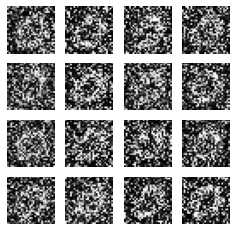

epoch:5|gen_cost:0.774386|disc_loss:1.208888|learning_rate:0.000999


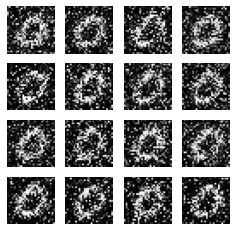

epoch:10|gen_cost:0.731001|disc_loss:1.306628|learning_rate:0.000996


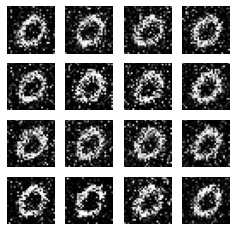

epoch:15|gen_cost:0.703813|disc_loss:1.363668|learning_rate:0.000990


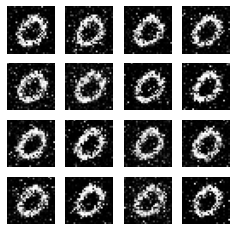

epoch:20|gen_cost:0.682852|disc_loss:1.399894|learning_rate:0.000981


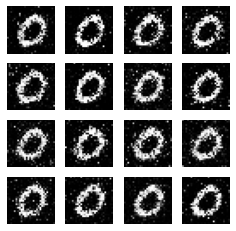

epoch:25|gen_cost:0.677030|disc_loss:1.415052|learning_rate:0.000970


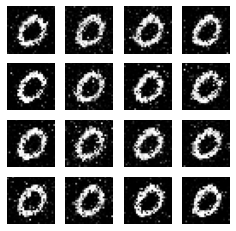

epoch:30|gen_cost:0.673295|disc_loss:1.423945|learning_rate:0.000957


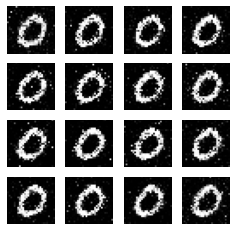

epoch:35|gen_cost:0.670328|disc_loss:1.429595|learning_rate:0.000942


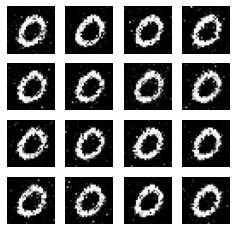

epoch:40|gen_cost:0.668465|disc_loss:1.432071|learning_rate:0.000925


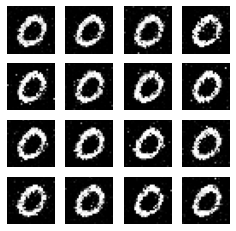

epoch:45|gen_cost:0.670173|disc_loss:1.429295|learning_rate:0.000906


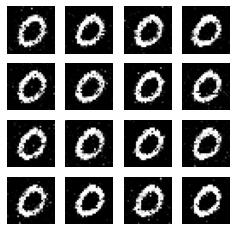

epoch:50|gen_cost:0.673690|disc_loss:1.423626|learning_rate:0.000885


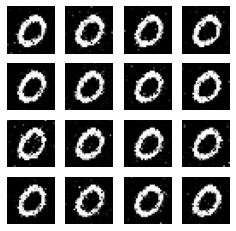

epoch:55|gen_cost:0.675782|disc_loss:1.418609|learning_rate:0.000862


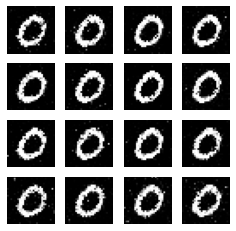

epoch:60|gen_cost:0.678066|disc_loss:1.412576|learning_rate:0.000838


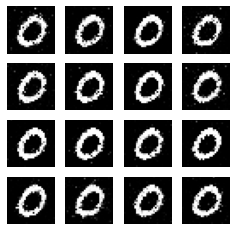

epoch:65|gen_cost:0.681740|disc_loss:1.404623|learning_rate:0.000813


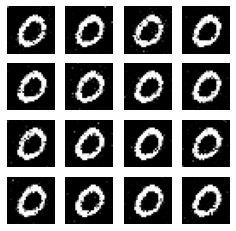

epoch:70|gen_cost:0.687443|disc_loss:1.394572|learning_rate:0.000786


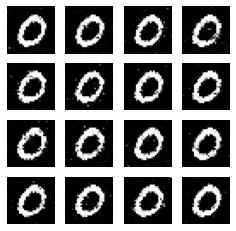

epoch:75|gen_cost:0.691451|disc_loss:1.385222|learning_rate:0.000758


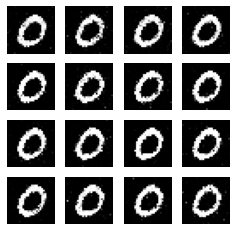

epoch:80|gen_cost:0.697465|disc_loss:1.374622|learning_rate:0.000730


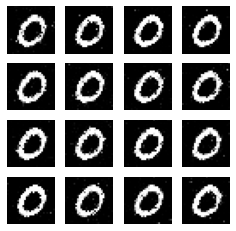

epoch:85|gen_cost:0.703283|disc_loss:1.363700|learning_rate:0.000700


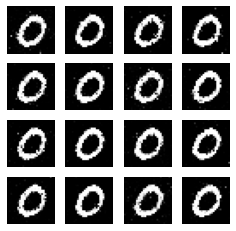

epoch:90|gen_cost:0.708575|disc_loss:1.352804|learning_rate:0.000671


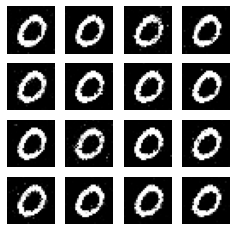

epoch:95|gen_cost:0.714445|disc_loss:1.341393|learning_rate:0.000641


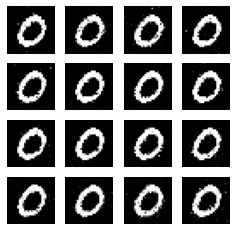

In [4]:
numbers = [0]
model_gan = GAN(numbers, learning_rate=1e-3, decay_rate=1e-4, epochs=100)
cost_func_disc, cost_func_gen = model_gan.train(x_train, y_train)